## Data Gathering Process - Using CVE API from NVD to Collect and Classify SSRF Vulnerability Data

In [1]:
import requests
import json
import pandas as pd
import re

# CVE API URL for SSRF vulnerabilities
cve_api_url = "https://services.nvd.nist.gov/rest/json/cves/2.0?keywordSearch=SSRF&resultsPerPage=2000"

# Send GET request to API
response = requests.get(cve_api_url)
if response.status_code == 200:
    data = response.json()
else:
    print(f"Error fetching data (Status Code: {response.status_code})")
    exit()

# Define a function to classify SSRF attack types from the description
def classify_attack(description):
    """Classifies SSRF attack types based on keywords and patterns in the description."""
    # Internal SSRF (Targeting internal systems like metadata services, localhost, or private IPs)
    if re.search(r'localhost|127\.0\.0\.1|169\.254|metadata|internal', description, re.IGNORECASE):
        return "Internal SSRF"
    # Protocol Abuse SSRF (Using gopher, dict, ftp, or other non-HTTP protocols)
    elif re.search(r'gopher://|file://|dict://|ftp://|http://localhost', description, re.IGNORECASE):
        return "Protocol Abuse SSRF"
    # DNS Rebinding SSRF (Abusing DNS resolution techniques)
    elif re.search(r'DNS|rebinding|resolve|hostname', description, re.IGNORECASE):
        return "DNS Rebinding SSRF"
    # Blind SSRF (No immediate feedback, often detected via external services)
    elif re.search(r'blind|out-of-band|OOB', description, re.IGNORECASE):
        return "Blind SSRF"
    # Cloud-Based SSRF (Targeting AWS, GCP, Azure, cloud storage, or metadata APIs)
    elif re.search(r'cloud|AWS|GCP|Azure|storage|bucket|cloud metadata', description, re.IGNORECASE):
        return "Cloud-Based SSRF"
    # Default: External SSRF (If none of the above match)
    else:
        return "External SSRF"

# Define a function to map CWE IDs to mitigation strategies
def map_mitigation(cwe_id):
    """Maps CWE IDs to security best practices for mitigation."""

    mitigation_dict = {
        "CWE-918": "Restrict internal network access, validate user input, use allowlists for URLs",
        "CWE-200": "Prevent sensitive data exposure using strict access control policies",
        "CWE-352": "Implement CSRF protection, enforce SameSite cookies, and use CSRF tokens",
        "CWE-400": "Use rate-limiting, request validation, and avoid unnecessary redirects",
        "CWE-601": "Prevent open redirects to untrusted domains, implement URL allowlists",
        "CWE-829": "Limit SSRF exposure by restricting external calls, use network segmentation",
        "CWE-94": "Sanitize input to prevent code injection through SSRF payloads",
        "CWE-287": "Ensure proper authentication mechanisms to block unauthorized requests",
        "CWE-610": "Use request signing to verify authenticity before processing external URLs",
        "CWE-441": "Restrict access to internal services from SSRF-exposed endpoints",
        "CWE-77": "Escape and validate input to prevent command injection via SSRF",
        "CWE-116": "Ensure error messages do not leak internal information",
        "CWE-185": "Sanitize and validate paths to prevent path traversal via SSRF",
        "CWE-611": "Disable XML external entity (XXE) processing to prevent SSRF exploitation",
        "CWE-113": "Prevent HTTP response splitting by sanitizing headers",
        "CWE-115": "Ensure proper encoding and decoding of transmitted data",
        "CWE-125": "Prevent out-of-bounds read attacks in memory manipulation",
        "CWE-1286": "Ensure proper authorization and access control for user actions",
        "CWE-20": "Implement strict input validation to prevent unexpected behavior",
        "CWE-201": "Limit the exposure of sensitive information in error messages",
        "CWE-22": "Prevent path traversal by validating and sanitizing input paths",
        "CWE-264": "Implement least privilege access control for all network services",
        "CWE-269": "Ensure proper role-based authentication and authorization",
        "CWE-288": "Require multi-factor authentication for sensitive resources",
        "CWE-330": "Use secure cryptographic randomness to prevent predictable exploits",
        "CWE-367": "Enforce race condition protections to prevent exploitation",
        "CWE-425": "Prevent unauthorized access to restricted URLs",
        "CWE-434": "Restrict file uploads to only expected content types",
        "CWE-502": "Sanitize and validate serialized data to prevent deserialization attacks",
        "CWE-691": "Ensure security mechanisms cannot be bypassed easily",
        "CWE-704": "Use strong type checking to prevent unexpected type manipulation",
        "CWE-74": "Sanitize user input to prevent injection attacks",
        "CWE-79": "Implement strict cross-site scripting (XSS) prevention mechanisms",
        "CWE-807": "Verify authenticity of received data before processing",
        "CWE-835": "Prevent infinite loops and excessive resource consumption",
        "CWE-862": "Enforce proper access control and authentication",
        "CWE-91": "Ensure secure data parsing to prevent code injection"
    }

    return mitigation_dict.get(cwe_id, "General SSRF Mitigation: Validate and sanitize all URLs, restrict network access, and enforce security controls.")

# Extract relevant features for ML model training
cve_records = []
for record in data.get("vulnerabilities", []):
    cve = record.get("cve", {})

    # Extract key details with default values if missing
    cve_id = cve.get("id", "N/A")
    description = cve.get("descriptions", [{}])[0].get("value", "No Description")
    severity = cve.get("metrics", {}).get("cvssMetricV31", [{}])[0].get("cvssData", {}).get("baseSeverity", "N/A")
    attack_complexity = cve.get("metrics", {}).get("cvssMetricV31", [{}])[0].get("cvssData", {}).get("attackComplexity", "N/A")
    attack_vector = cve.get("metrics", {}).get("cvssMetricV31", [{}])[0].get("cvssData", {}).get("vectorString", "N/A")
    cwe_id = cve.get("weaknesses", [{}])[0].get("description", [{}])[0].get("value", "N/A")

    # Extract References (URLs)
    references = [ref.get("url", "No Reference") for ref in cve.get("references", [])]

    # Classify Attack Type
    attack_type = classify_attack(description)

    # Map CWE ID to Mitigation Strategy
    mitigation = map_mitigation(cwe_id)

    # Store extracted data
    cve_records.append({
        "CVE ID": cve_id,
        "Description": description,
        "Severity": severity,
        "Attack Complexity": attack_complexity,
        "Attack Vector": attack_vector,
        "CWE ID": cwe_id,
        "References": ", ".join(references),  # Convert list to string
        "Attack Type": attack_type,
        "Mitigation Strategy": mitigation
    })

# Convert to Pandas DataFrame
df = pd.DataFrame(cve_records)

# Save as CSV for ML training
df.to_csv("ssrf_cve_dataset.csv", index=False)

print("Data successfully fetched and saved as ssrf_cve_dataset.csv for ML model training!")


Data successfully fetched and saved as ssrf_cve_dataset.csv for ML model training!


## Load the necessary libraries for data pre-processing, visualisation and training the ML algorithms models.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
#Load the SSRF Vulnerabilities dataset and convert to Pandas DataFrame for data analysis
df = pd.read_csv('ssrf_cve_dataset.csv')

In [4]:
#Preview the dataframe first few rows
df.head()

,CVE ID,Description,Severity,Attack Complexity,Attack Vector,CWE ID,References,Attack Type,Mitigation Strategy
0,CVE-2014-9304,Plex Media Server before 0.9.9.3 allows remote...,NaN,NaN,NaN,CWE-264,"http://www.securityfocus.com/archive/1/531290,...",External SSRF,Implement least privilege access control for a...
1,CVE-2014-6577,Unspecified vulnerability in the XML Developer...,NaN,NaN,NaN,NVD-CWE-noinfo,http://www.oracle.com/technetwork/topics/secur...,Internal SSRF,General SSRF Mitigation: Validate and sanitize...
2,CVE-2016-4029,WordPress before 4.5 does not consider octal a...,HIGH,LOW,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:N/I:H/A:N,CWE-918,"http://codex.wordpress.org/Version_4.5, http:/...",External SSRF,"Restrict internal network access, validate use..."
3,CVE-2016-6483,The media-file upload feature in vBulletin bef...,NaN,NaN,NaN,CWE-918,http://legalhackers.com/advisories/vBulletin-S...,External SSRF,"Restrict internal network access, validate use..."
4,CVE-2016-7964,The sendRequest method in HTTPClient Class in ...,NaN,NaN,NaN,CWE-918,"http://www.securityfocus.com/bid/94245, https:...",Internal SSRF,"Restrict internal network access, validate use..."


In [5]:
# Count how many descriptions defaulted to 'External SSRF'
default_count = df[df["Attack Type"] == "External SSRF"].shape[0]
print(f"Number of CVEs defaulted to 'External SSRF': {default_count}")

# Percentage of total
default_percentage = (default_count / len(df)) * 100
print(f"Percentage of total: {default_percentage:.2f}%")

Number of CVEs defaulted to 'External SSRF': 332
Percentage of total: 68.17%


In [6]:
import random

# Get 10 random samples
sampled_rows = df.sample(50)

# Print CVE ID, Description, and Attack Type
for index, row in sampled_rows.iterrows():
    print(f"CVE ID: {row['CVE ID']}")
    print(f"Description: {row['Description']}")
    print(f"Mapped Attack Type: {row['Attack Type']}")
    print("-" * 80)

CVE ID: CVE-2018-14514
Description: An SSRF vulnerability was discovered in idreamsoft iCMS V7.0.9 that allows attackers to read sensitive files, access an intranet, or possibly have unspecified other impact.
Mapped Attack Type: External SSRF
--------------------------------------------------------------------------------
CVE ID: CVE-2024-6763
Description: Eclipse Jetty is a lightweight, highly scalable, Java-based web server and Servlet engine . It includes a utility class, HttpURI, for URI/URL parsing.

The HttpURI class does insufficient validation on the authority segment of a URI.  However the behaviour of HttpURI
 differs from the common browsers in how it handles a URI that would be 
considered invalid if fully validated against the RRC.  Specifically HttpURI
 and the browser may differ on the value of the host extracted from an 
invalid URI and thus a combination of Jetty and a vulnerable browser may
 be vulnerable to a open redirect attack or to a SSRF attack if the URI 
is us

In [7]:
print(df['Attack Type'].value_counts())  # Check distribution of attack types
print(df['Mitigation Strategy'].value_counts())  # Check mitigation class balance

Attack Type
External SSRF          332
Internal SSRF           91
Blind SSRF              36
DNS Rebinding SSRF      15
Cloud-Based SSRF         8
Protocol Abuse SSRF      5
Name: count, dtype: int64
Mitigation Strategy
Restrict internal network access, validate user input, use allowlists for URLs                                      375
Disable XML external entity (XXE) processing to prevent SSRF exploitation                                            40
General SSRF Mitigation: Validate and sanitize all URLs, restrict network access, and enforce security controls.     11
Implement CSRF protection, enforce SameSite cookies, and use CSRF tokens                                              7
Prevent path traversal by validating and sanitizing input paths                                                       7
Implement strict input validation to prevent unexpected behavior                                                      7
Implement strict cross-site scripting (XSS) prevention mecha

In [8]:
# Check if rows with missing details/NaN or NULL values exists
df.isnull().sum()

,0
CVE ID,0
Description,0
Severity,122
Attack Complexity,122
Attack Vector,122
CWE ID,10
References,0
Attack Type,0
Mitigation Strategy,0


In [9]:
#Displays info about dataframe such as null values, columns and entries.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CVE ID               487 non-null    object
 1   Description          487 non-null    object
 2   Severity             365 non-null    object
 3   Attack Complexity    365 non-null    object
 4   Attack Vector        365 non-null    object
 5   CWE ID               477 non-null    object
 6   References           487 non-null    object
 7   Attack Type          487 non-null    object
 8   Mitigation Strategy  487 non-null    object
dtypes: object(9)
memory usage: 34.4+ KB


### Total No. of Rows before removing NaN Values: 487
### After removing NaN values: 358

In [10]:
# Remove these null entries in columns from dataset
df = df.dropna(subset=['Severity', 'Attack Complexity', 'Attack Vector', 'CWE ID'])

# Verify that these null entries are removed from columns data
print(df.isnull().sum())

# New number of rows after cleaning up
print("New no. of rows: " + str(len(df)))

CVE ID                 0
Description            0
Severity               0
Attack Complexity      0
Attack Vector          0
CWE ID                 0
References             0
Attack Type            0
Mitigation Strategy    0
dtype: int64
New no. of rows: 358


In [11]:
#Further pre-processing from feature selection by keeping only relevant columns for further analysis
relevant_columns = ['CVE ID', 'CWE ID', 'Attack Type', 'Mitigation Strategy']
df = df[relevant_columns]

In [12]:
#Check for any duplicate rows to ensure accurate analysis
print("Duplicate rows count:", df.duplicated().sum())

Duplicate rows count: 0


In [13]:
#Preview the first few rows of dataset after removal of NaN values
df.head()

,CVE ID,CWE ID,Attack Type,Mitigation Strategy
2,CVE-2016-4029,CWE-918,External SSRF,"Restrict internal network access, validate use..."
24,CVE-2017-17697,CWE-918,External SSRF,"Restrict internal network access, validate use..."
65,CVE-2018-1000823,CWE-611,External SSRF,Disable XML external entity (XXE) processing t...
69,CVE-2018-1000828,CWE-611,External SSRF,Disable XML external entity (XXE) processing t...
76,CVE-2018-1000835,CWE-611,External SSRF,Disable XML external entity (XXE) processing t...


## Exploratory Data Analysis

<ipython-input-14-ff7f06279148>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attack Type', data=df, palette="viridis")


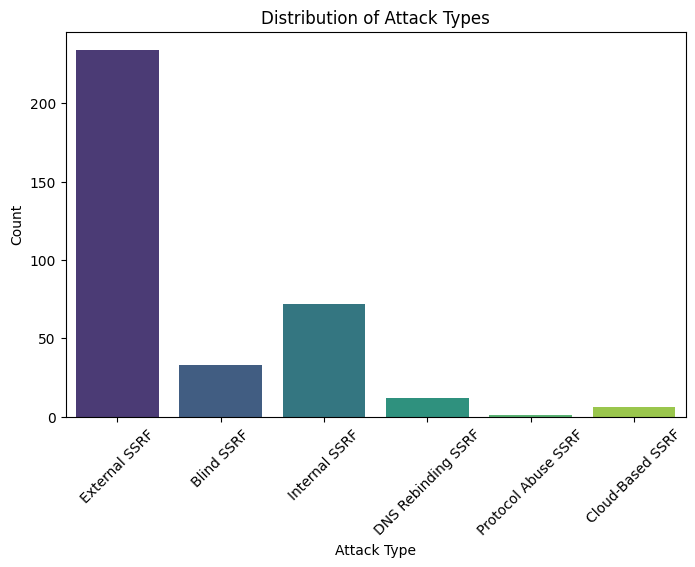

In [14]:
# Distribution of Attack Types with total counts
plt.figure(figsize=(8, 5))
sns.countplot(x='Attack Type', data=df, palette="viridis")
plt.title("Distribution of Attack Types")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

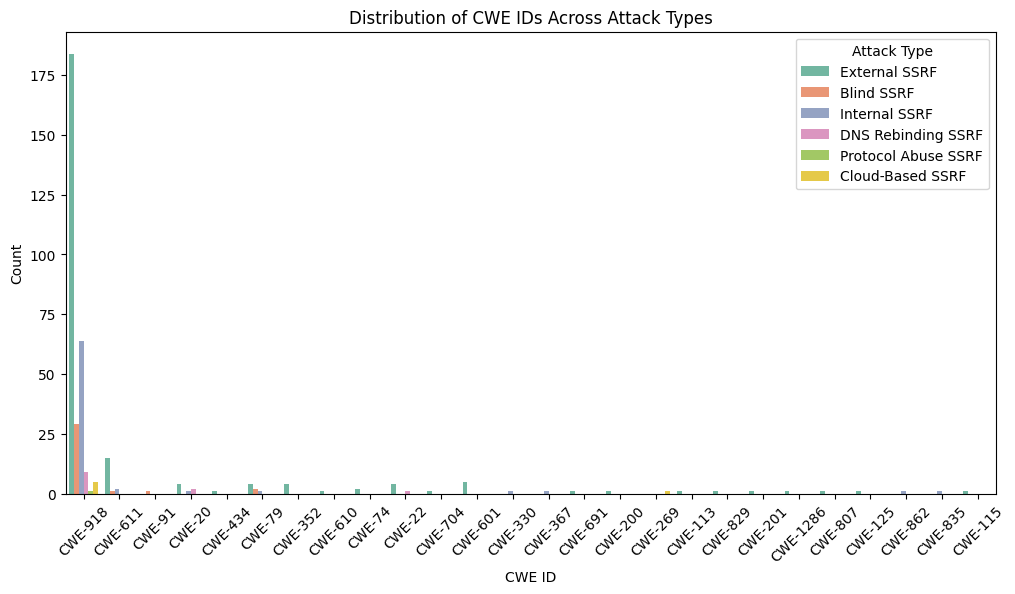

In [15]:
## Distribution Analysis (CWE IDs Across Attack Types) with total counts
plt.figure(figsize=(12, 6))
sns.countplot(x="CWE ID", hue="Attack Type", data=df, palette="Set2")
plt.xticks(rotation=45)
plt.title("Distribution of CWE IDs Across Attack Types")
plt.xlabel("CWE ID")
plt.ylabel("Count")
plt.legend(title="Attack Type")
plt.show()

In [16]:
# Encoding categorical variables into numerical values for model training
label_encoders = {}
for col in ['Attack Type', 'Mitigation Strategy']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for future reference

In [17]:
# Print label mapping for each encoded column
for col in ['Attack Type', 'Mitigation Strategy']:
    print(f"\nLabel Encoding Mapping for {col}:")
    for class_index, class_label in enumerate(label_encoders[col].classes_):
        print(f" {class_label} --> {class_index}")


Label Encoding Mapping for Attack Type:
 Blind SSRF --> 0
 Cloud-Based SSRF --> 1
 DNS Rebinding SSRF --> 2
 External SSRF --> 3
 Internal SSRF --> 4
 Protocol Abuse SSRF --> 5

Label Encoding Mapping for Mitigation Strategy:
 Disable XML external entity (XXE) processing to prevent SSRF exploitation --> 0
 Enforce proper access control and authentication --> 1
 Enforce race condition protections to prevent exploitation --> 2
 Ensure proper authorization and access control for user actions --> 3
 Ensure proper encoding and decoding of transmitted data --> 4
 Ensure proper role-based authentication and authorization --> 5
 Ensure secure data parsing to prevent code injection --> 6
 Ensure security mechanisms cannot be bypassed easily --> 7
 Implement CSRF protection, enforce SameSite cookies, and use CSRF tokens --> 8
 Implement strict cross-site scripting (XSS) prevention mechanisms --> 9
 Implement strict input validation to prevent unexpected behavior --> 10
 Limit SSRF exposure by r

In [18]:
#Confirm the label encoding for the following columns are successsfully applied
df.head()

,CVE ID,CWE ID,Attack Type,Mitigation Strategy
2,CVE-2016-4029,CWE-918,3,20
24,CVE-2017-17697,CWE-918,3,20
65,CVE-2018-1000823,CWE-611,3,0
69,CVE-2018-1000828,CWE-611,3,0
76,CVE-2018-1000835,CWE-611,3,0


In [19]:
# Remove "CWE-" prefix and convert to numeric for model training
df['CWE ID'] = df['CWE ID'].str.replace("CWE-", "").astype(int)  # Convert "CWE-918" → 918

# Verify the DataFrame
df.head()

,CVE ID,CWE ID,Attack Type,Mitigation Strategy
2,CVE-2016-4029,918,3,20
24,CVE-2017-17697,918,3,20
65,CVE-2018-1000823,611,3,0
69,CVE-2018-1000828,611,3,0
76,CVE-2018-1000835,611,3,0


In [20]:
# Save preprocessed dataset
df.to_csv("preprocessed_ssrf_dataset.csv", index=False)
print("Data preprocessing completed. Preprocessed dataset saved as 'preprocessed_ssrf_dataset.csv'")

Data preprocessing completed. Preprocessed dataset saved as 'preprocessed_ssrf_dataset.csv'


## Train the ML Model Algorithms - trains and evaluates classification models to predict mitigation strategies for SSRF (Server-Side Request Forgery) attacks based on CWE ID and Attack Type

In [21]:
# Define independent variables (X) and dependent variable (y)
X = df[['CWE ID', 'Attack Type']]  # Features
y = df['Mitigation Strategy']  # Target (Labels)

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Decision Tree Model Performance:
Accuracy: 0.9722

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           7       0.00      1.00      0.00         0
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.00      1.00      0.00         0
          15       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          20       1.00      1.00      1.00        52
          21       1.00      1.00      1.00         1
          24       1.00      0.00      0.00         1
          25       1.00      0.00      0.00         1

    accuracy                           0.97        72
   macro avg       0.83      0.83      0.67        72
weighted avg       1.00      0.97      0.97        72



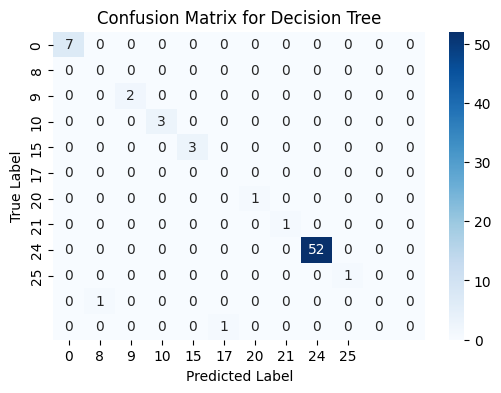


XGBoost Model Performance:
Accuracy: 0.9583

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           7       0.00      1.00      0.00         0
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          20       1.00      1.00      1.00        52
          21       1.00      0.00      0.00         1
          24       1.00      0.00      0.00         1
          25       1.00      0.00      0.00         1

    accuracy                           0.96        72
   macro avg       0.89      0.73      0.62        72
weighted avg       0.99      0.96      0.95        72



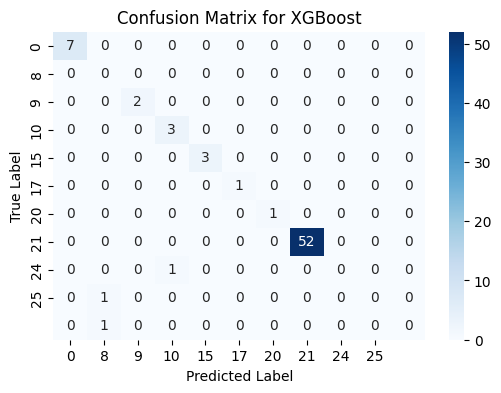


Random Forest Model Performance:
Accuracy: 0.9167

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           6       0.00      1.00      0.00         0
           7       0.00      1.00      0.00         0
           8       1.00      1.00      1.00         2
           9       1.00      0.00      0.00         3
          10       1.00      0.67      0.80         3
          11       0.00      1.00      0.00         0
          15       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          20       1.00      1.00      1.00        52
          21       1.00      1.00      1.00         1
          23       0.00      1.00      0.00         0
          24       1.00      0.00      0.00         1
          25       1.00      0.00      0.00         1

    accuracy                           0.92        72
   macro avg       0.71      0.76      0.49        72
weig

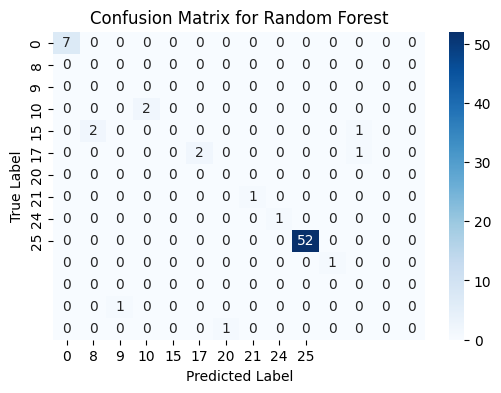

In [22]:
# Function to train & evaluate models
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Evaluation Metrics
    # Compute Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute Classification Report
    report = classification_report(y_test, y_pred, zero_division=1)

    # Print Model Performance
    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

    return model

# Train & Evaluate Models
dt_model = train_and_evaluate(DecisionTreeClassifier(random_state=42), "Decision Tree")
xgb_model = train_and_evaluate(XGBClassifier(eval_metric="mlogloss", random_state=42), "XGBoost")
rf_model = train_and_evaluate(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest")

In [28]:
# Testing of best performance decisioin tree model to predict correct mitigation strategy/recommendations based on features trained

# CWE ID to CWE Name Mapping
cwe_name_mapping = {
    918: "Server-Side Request Forgery (SSRF)",
    200: "Exposure of Sensitive Information to an Unauthorized Actor",
    352: "Cross-Site Request Forgery (CSRF)",
    400: "Uncontrolled Resource Consumption",
    601: "URL Redirection to Untrusted Site ('Open Redirect')",
    829: "Inclusion of Functionality from Untrusted Control Sphere",
    94: "Code Injection",
    287: "Improper Authentication",
    610: "Externally Controlled Reference to a Resource in Another Sphere",
    441: "Unintended Proxy or Intermediary ('Confused Deputy')",
    77: "Command Injection",
    116: "Improper Encoding or Escaping of Output",
    185: "Incorrect Authorization",
    611: "Improper Restriction of XML External Entity Reference (XXE)",
    113: "Improper Neutralization of CRLF Sequences in HTTP Headers ('HTTP Response Splitting')",
    115: "Improper Neutralization of Input During Writing of Files",
    125: "Out-of-bounds Read",
    1286: "Improper Access Control",
    20: "Improper Input Validation",
    201: "Information Exposure Through Sent Data",
    22: "Path Traversal",
    264: "Permissions, Privileges, and Access Control",
    269: "Improper Privilege Management",
    288: "Authentication Bypass Issues",
    330: "Use of Insufficiently Random Values",
    367: "Time-of-check Time-of-use (TOCTOU) Race Condition",
    425: "Direct Request ('Forced Browsing')",
    434: "Unrestricted File Upload",
    502: "Deserialization of Untrusted Data",
    691: "Insufficient Control Flow Management",
    704: "Incorrect Type Conversion or Cast",
    74: "Improper Neutralization of Special Elements in Output Used by a Downstream Component ('Injection')",
    79: "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')",
    807: "Reliance on Untrusted Inputs in a Security Decision",
    835: "Loop with Unreachable Exit Condition ('Infinite Loop')",
    862: "Missing Authorization",
    91: "XML Injection (aka Blind XPath Injection)"
}

# Attack Type Mapping Dictionary
attack_type_mapping = {
    0: "Blind SSRF",
    1: "Cloud-Based SSRF",
    2: "DNS Rebinding SSRF",
    3: "External SSRF",
    4: "Internal SSRF",
    5: "Protocol Abuse SSRF"
}

# Define function for mitigation prediction based on CWE ID, Attack Type input features
def predict_mitigation(model, cwe_id, attack_type):
    # Convert input to DataFrame to avoid feature name warning
    input_data = pd.DataFrame([[cwe_id, attack_type]], columns=['CWE ID', 'Attack Type'])

    # Predict mitigation strategy
    prediction = model.predict(input_data)[0]

    # Convert back to label
    mitigation_strategy = label_encoders['Mitigation Strategy'].inverse_transform([prediction])[0]

    # Get CWE Name and Attack Type Name
    cwe_name = cwe_name_mapping.get(cwe_id, f"CWE {cwe_id}")
    attack_type_name = attack_type_mapping.get(attack_type, f"Attack Type {attack_type}")

    return cwe_name, attack_type_name, mitigation_strategy

# Testing of the mapping to mitigation strategy/recommendation prediction from CWE ID of vulnerability and attack type for reference using decision tree model
cwe_example = 918  # Example input of CWE ID
attack_type_example = 2 # Example input of attack type

# Predict mitigation strategy
cwe_name, attack_type_name, predicted_remediation = predict_mitigation(dt_model, cwe_example, attack_type_example)

# Print the formatted result
print(f"\nPredicted Mitigation Strategy for CWE {cwe_example} ({cwe_name}) & Attack Type of vulnerability ({attack_type_name}): {predicted_remediation}")


Predicted Mitigation Strategy for CWE 918 (Server-Side Request Forgery (SSRF)) & Attack Type of vulnerability (DNS Rebinding SSRF): Restrict internal network access, validate user input, use allowlists for URLs


## Deploy the best performance Decision Tree model using Pickle for further use in deployed environment

In [29]:
import pickle

# Save the trained Decision Tree model to deploy the model for further use
with open("decision_tree_model.pkl", "wb") as model_file:
    pickle.dump(dt_model, model_file)

print("Decision Tree model saved successfully!")


Decision Tree model saved successfully!


In [30]:
# Load the trained Decision Tree model to use in deployed environment
with open("decision_tree_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

print("Decision Tree model loaded successfully!")

Decision Tree model loaded successfully!


In [34]:
# Make predictions on mitigation strategies using the best performance decision tree model once loaded

''' Map CWE ID to its corresponding name using a predefined dictionary (cwe_names),
Ensure attack type name is used instead of the encoded number used for training.
'''
cwe_names = {
    918: "Server-Side Request Forgery (SSRF)",
    200: "Exposure of Sensitive Information to an Unauthorized Actor",
    352: "Cross-Site Request Forgery (CSRF)",
    400: "Uncontrolled Resource Consumption",
    601: "URL Redirection to Untrusted Site ('Open Redirect')",
    829: "Inclusion of Functionality from Untrusted Control Sphere",
    94: "Code Injection",
    287: "Improper Authentication",
    610: "Externally Controlled Reference to a Resource in Another Sphere",
    441: "Unintended Proxy or Intermediary ('Confused Deputy')",
    77: "Command Injection",
    116: "Improper Encoding or Escaping of Output",
    185: "Incorrect Authorization",
    611: "Improper Restriction of XML External Entity Reference (XXE)",
    113: "Improper Neutralization of CRLF Sequences in HTTP Headers ('HTTP Response Splitting')",
    115: "Improper Neutralization of Input During Writing of Files",
    125: "Out-of-bounds Read",
    1286: "Improper Access Control",
    20: "Improper Input Validation",
    201: "Information Exposure Through Sent Data",
    22: "Path Traversal",
    264: "Permissions, Privileges, and Access Control",
    269: "Improper Privilege Management",
    288: "Authentication Bypass Issues",
    330: "Use of Insufficiently Random Values",
    367: "Time-of-check Time-of-use (TOCTOU) Race Condition",
    425: "Direct Request ('Forced Browsing')",
    434: "Unrestricted File Upload",
    502: "Deserialization of Untrusted Data",
    691: "Insufficient Control Flow Management",
    704: "Incorrect Type Conversion or Cast",
    74: "Improper Neutralization of Special Elements in Output Used by a Downstream Component ('Injection')",
    79: "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')",
    807: "Reliance on Untrusted Inputs in a Security Decision",
    835: "Loop with Unreachable Exit Condition ('Infinite Loop')",
    862: "Missing Authorization",
    91: "XML Injection (aka Blind XPath Injection)"
}

# Mapping to mitigation strategy/recommendation prediction from CWE ID of vulnerability and attack type using decision tree model
cwe_example = 918  # Example CWE ID
attack_type_example = 3  # Example Attack Type for reference

# Convert input to DataFrame
input_data = pd.DataFrame([[cwe_example, attack_type_example]], columns=['CWE ID', 'Attack Type'])

# Predict the mitigation strategy
prediction = loaded_model.predict(input_data)[0]

# Convert back to label using stored label encoder
predicted_mitigation = label_encoders["Mitigation Strategy"].inverse_transform([prediction])[0]

# Get CWE Name (Ensure default if not found)
cwe_name = cwe_names.get(cwe_example, f"{cwe_example}")

# Get Attack Type Name using the Label Encoder
attack_type_name = label_encoders["Attack Type"].inverse_transform([attack_type_example])[0]

# Print the formatted output
print(f"Predicted Mitigation Strategy for CWE {cwe_example} ({cwe_name}) & Attack Type of vulnerability ({attack_type_name}): {predicted_mitigation}")

Predicted Mitigation Strategy for CWE 918 (Server-Side Request Forgery (SSRF)) & Attack Type of vulnerability (External SSRF): Restrict internal network access, validate user input, use allowlists for URLs
